# Analysis & Visualization of Produced Water Chemistry for Environmental & Agricultural Utilization

In [3]:
# Dependencies
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import sklearn
from wqchartpy import triangle_piper

## DATA CLEANING & FILTERING

In [4]:
# Load the data from the CSV files
df1 = pd.read_csv('../data/split_1_USGSPWDBv2.3n.csv', low_memory=False)
df2 = pd.read_csv('../data/split_2_USGSPWDBv2.3n.csv', low_memory=False)
df3 = pd.read_csv('../data/split_3_USGSPWDBv2.3n.csv', low_memory=False)

# Concatenate the dataframes
frames = [df1, df2, df3]
df_merged = pd.concat(frames, ignore_index=True)

# Save the concatenated dataframe to a new CSV file
df_merged.to_csv('../data/df_merged.csv', index=False)

In [5]:
# List of columns to be removed
columns_to_remove = [
    "IDDB", "SOURCE", "REFERENCE", "LATLONGAPX", "USGSREGION", "BASINCODE", 
    "STATECODE", "COUNTYCODE", "FIELD", "FIELDCODE", "WELLCODE", "TOWNRANGE", 
    "REGDIST", "LOC", "QUAD", "DAY", "DATECOMP", "DATEANALYS", "METHOD", 
    "OPERATOR", "PERMIT", "DFORM", "GROUP", "MEMBER", "AGECODE", "ERA", 
    "PERIOD", "EPOCH", "LAB", "REMARKS", "LITHOLOGY", "POROSITY", "TEMP", 
    "PRESSURE", "SG", "SPGRAV", "SPGRAVT", "RESIS", "RESIST", "PH", "PHT", 
    "EHORP", "COND", "CONDT", "TURBIDITY", "HEM", "MBAS","TDS","TDSCALC", "TSS", "CHARGEBAL", 
    "ACIDITY", "DIC", "DOC", "TOC", "CN", "BOD", "COD", "BENZENE", "TOLUENE", 
    "ETHYLBENZ", "XYLENE", "ACETATE", "BUTYRATE", "FORMATE", "LACTATE", 
    "PHENOLS", "PERC", "PROPIONATE", "PYRUVATE", "VALERATE", "ORGACIDS", 
    "Ar", "CH4", "C2H6", "CO2", "H2", "H2S", "He", "N2", "NH3", "O2", "ALPHA", 
    "BETA", "dD", "H3", "d7Li", "d11B", "d13C", "C14", "d18O", "d34S", 
    "d37Cl", "K40", "d81Br", "Sr87Sr86", "I129", "Rn222", "Ra226", "Ra228", 
    "cull_PH", "cull_MgCa", "cull_KCl", "cull_K5Na", "Ag", "Al", "As", "Au", 
    "B", "BO3", "Be", "Bi", "Cd", "Co", "Cr", "Cs", "Cu", "F", "FeS", "FeAl", 
    "FeAl2O3", "Hg", "I", "Mn", "Mo", "N", "NO2", "NO3", "NO3NO2", "NH4", 
    "TKN", "Ni", "OH", "P", "PO4", "Pb", "Rh", "Rb", "S", "SO3", "HS", "Sb", 
    "Sc", "Se", "Sn", "Ti", "Tl", "U", "V", "W", "Zn"
]

# Remove the specified columns
df_limited_column = df_merged.drop(columns=columns_to_remove, errors='ignore')

# Display the updated merged dataframe
df_limited_column.to_csv('../data/df_limited_column.csv', index=False)

In [6]:
# Remove rows where TDSUSGS <= 35000 (sea water to eliminate all colebed methane produced water and also the failing analyses)
df_filtered = df_limited_column[df_limited_column['TDSUSGS'] > 35000]

# Save the filtered dataframe to a new CSV file
df_filtered.to_csv('../data/df_filtered_TDS.csv', index=False)

In [8]:
# Fill NaN values in 'KNa', 'K', 'Na', 'Ca', 'Cl', 'SO4', 'Mg' with zeros for calculation
for col in ['KNa', 'K', 'Na', 'Ca', 'Cl', 'SO4', 'Mg']:
    df_filtered[col].fillna(0, inplace=True)

# First, we'll fill NaN values in 'KNa' and 'K' with zeros for the calculation.
df_filtered['KNa'].fillna(0, inplace=True)
df_filtered['K'].fillna(0, inplace=True)

# Apply conditions to calculate 'Na'
# If 'Na' is missing and both 'KNa' and 'K' are present, populate 'Na' with 'KNa' - 'K'
# If 'Na' is missing and 'KNa' is present but 'K' is not, populate 'Na' with 'KNa'

na_mask = df_filtered['Na'].isna()
na_present = df_filtered['Na'] > 0
kna_present = df_filtered['KNa'] > 0
k_present = df_filtered['K'] > 0
k_missing = df_filtered['K'] == 0

df_filtered.loc[k_missing & na_present & kna_present, 'K'] = df_filtered['KNa'] - df_filtered['Na']
df_filtered.loc[na_mask & kna_present & k_present, 'Na'] = df_filtered['KNa'] - df_filtered['K']
df_filtered.loc[na_mask & kna_present & ~k_present, 'Na'] = df_filtered['KNa']

# Remove rows where 'Na' is still missing
df_filtered.dropna(subset=['Na'], inplace=True)

# Remove rows where 'Cl' is missing
df_filtered.dropna(subset=['Cl'], inplace=True)

# Save the updated dataframe 
df_filtered.to_csv('../data/df_filtered_Na_Cl.csv', index=False)

C:\Users\ajuar\AppData\Local\Temp\ipykernel_2396\3587715086.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col].fillna(0, inplace=True)
C:\Users\ajuar\AppData\Local\Temp\ipykernel_2396\3587715086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['KNa'].fillna(0, inplace=True)
C:\Users\ajuar\AppData\Local\Temp\ipykernel_2396\3587715086.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['K'].fi

In [9]:
#To calculate the molar concentrations from concentrations given in ppm (parts per million) or mg/L,
#these values need to be converted into moles per liter (M). The formula to convert ppm or mg/L to M is:

                #Molarity (M)=Concentration (mg/L)/ Molar Mass (g/mol) 

#This calculation assumes that 1 ppm is equivalent to 1 mg/L. The molar mass of each element or compound (Na, Ca, Cl, SO4, and Mg) 
#is a constant value based on its atomic or molecular weight.

#Apply the conditions (molar Na > molar Ca) and (molar Cl > molar SO4) and (molar Ca > molar Mg/2) which represent likely unnatural combinations
# Convert concentrations from ppm (mg/L) to Molarity (M)
molar_masses = {'Na': 22.99, 'Ca': 40.08, 'Cl': 35.45, 'SO4': 96.06, 'Mg': 24.305}
for element, molar_mass in molar_masses.items():
    df_filtered[element + '_M'] = df_filtered[element] / molar_mass

# Apply the conditions (molar Na > molar Ca) and (molar Cl > molar SO4) and (molar Ca > molar Mg/2)
condition = (df_filtered['Na_M'] > df_filtered['Ca_M']) & \
            (df_filtered['Cl_M'] > df_filtered['SO4_M']) & \
            (df_filtered['Ca_M'] > df_filtered['Mg_M'] / 2)


df_filtered = df_filtered[condition]

# Save the updated dataframe
df_filtered.to_csv('../data/df_filtered_corrected_elemental_ratios.csv', index=False)

C:\Users\ajuar\AppData\Local\Temp\ipykernel_2396\2291718414.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[element + '_M'] = df_filtered[element] / molar_mass
C:\Users\ajuar\AppData\Local\Temp\ipykernel_2396\2291718414.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[element + '_M'] = df_filtered[element] / molar_mass
C:\Users\ajuar\AppData\Local\Temp\ipykernel_2396\2291718414.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [10]:
# Filter out rows where USGS charge balance is not between -10 and +10
df_filtered = df_filtered[df_filtered['chargebalance'].between(-10, 10)]

# Save the updated dataframe
df_filtered.to_csv('../data/df_filtered_chargebalance.csv', index=False)

In [11]:
# Calculate charge balance
df_filtered['Cations'] = (df_filtered['Na_M'] * 1) + (df_filtered['Ca_M'] * 2) + (df_filtered['Mg_M'] * 2)
df_filtered['Anions'] = (df_filtered['Cl_M'] * 1) + (df_filtered['SO4_M'] * 2)
df_filtered['CalculatedChargeBalance'] = ((df_filtered['Cations'] - df_filtered['Anions']) / (df_filtered['Cations'] + df_filtered['Anions'])) * 100

# Flag discrepancies between calculated charge balance and existing 'chargebalance' column
threshold = 5  # 5% threshold for discrepancy
df_filtered['ChargeBalanceDiscrepancy'] = abs(df_filtered['CalculatedChargeBalance'] - df_filtered['chargebalance']) > threshold

# Save the updated dataframe with discrepancy flags
df_filtered.to_csv('../data/df_filtered_discrepancy_flags.csv', index=False)

In [12]:
#Replace missing CO3 with 0's
df_filtered['CO3'].fillna(0, inplace=True)

#Replace missing HCO3 with ALKHCO3 where available
df_filtered['HCO3'].fillna(df_filtered['ALKHCO3'], inplace=True)

#Calculate HCO3 if both HCO3 and ALKHCO3 are missing
mask = df_filtered['HCO3'].isna() & df_filtered['ALKHCO3'].isna()
df_filtered.loc[mask, 'HCO3'] = (df_filtered['Cations'] - df_filtered['Anions']) / 61.0702

# Save thdf_filtered.to_csv('../data/df_filtered_estimated_HCO3.csv', index=False)e updated dataframe with estimated HCO3

## ANALYSIS 

In [13]:
# Define a function for a linear regression plot

from scipy.stats import linregress

def linear_regression_plot(x, y, ylabel_):
    # Perform linear regression
    slope, intercept, rvalue, pvalue, stderr = linregress(x, y)
    
    # Generate y values based on the regression line
    regression_line = slope * x + intercept
    eqn = 'y = ' + str(round(slope, 2)) + 'x + ' + str(round(intercept, 2))
    
    # Plot the data points
    plt.scatter(x, y)
    
    # Plot the regression line
    plt.plot(x, regression_line, 'r-')

    # Add labels
    plt.xlabel('Lithium')
    plt.ylabel(ylabel_)
    
    # Display the plot
    print(f'R value: {rvalue**2}')
    print(f'Correlation coefficient (r): {rvalue}')
    plt.show()

In [14]:
# Create new data frame for only lithium and upper depth values
df_li_depth = df_filtered[['Li', 'DEPTHUPPER']]
# Create new data frame to use for the 
df_regression = df_li_depth.dropna(subset=['Li', 'DEPTHUPPER'])

# Create new csv file for only original lithium and depth values
df_li_depth.to_csv('../data/df_regression.csv', index=False)

R value: 0.00783973017179147
Correlation coefficient (r): 0.08854225077211145


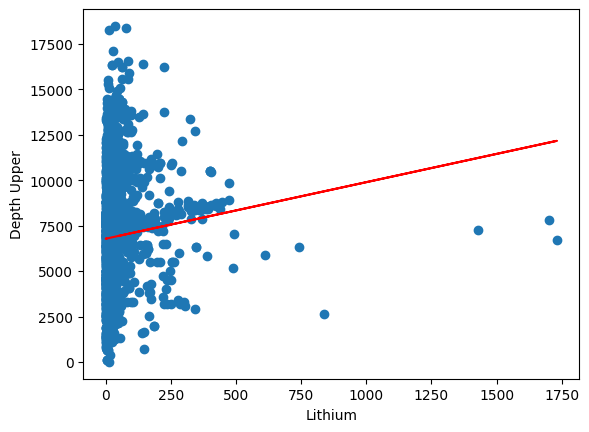

In [15]:
# Create a linear regression plot between Upper Depth and Lithium
linear_regression_plot(df_regression['Li'], df_regression['DEPTHUPPER'], 'Depth Upper')

In [16]:
# Set the correlation value found from the regression plot above
correlation = 0.0885

# Iterate through each column with missing values
for col in df_li_depth.columns:
    # Find columns with missing values
    if df_li_depth[col].isnull().any():
        # Find the non-missing column with the highest correlation
        correlated_col = df_li_depth.corr()[col].drop(col).idxmin()

        # Fill missing values using the specified correlation coefficient
        df_li_depth[col].fillna(df_li_depth[correlated_col] * correlation, inplace=True)


# Get rid of rows that are still blank
df_li_depth = df_li_depth.dropna(subset=['Li', 'DEPTHUPPER'])
# Create a new csv file showing the filled in lithium and upper depth values
df_li_depth.to_csv('../data/df_li_depth.csv', index=False)
# Show the dataframe after filling in the blanks
df_li_depth

C:\Users\ajuar\AppData\Local\Temp\ipykernel_2396\1859344543.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_li_depth[col].fillna(df_li_depth[correlated_col] * correlation, inplace=True)
C:\Users\ajuar\AppData\Local\Temp\ipykernel_2396\1859344543.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_li_depth[col].fillna(df_li_depth[correlated_col] * correlation, inplace=True)


,Li,DEPTHUPPER
64,19.800,1.75230
68,201.000,17.78850
69,202.000,17.87700
70,91.000,8.05350
72,34.100,3.01785
...,...,...
114799,1090.851,12326.00000
114807,712.071,8046.00000
114810,1494.411,16886.00000
114897,946.950,10700.00000


## VISUALIZATION

In [ ]:
# Dependencies
from wqchartpy import triangle_piper
from wqchartpy import contour_piper
from wqchartpy import color_piper

def move_wqchartpy_image_file_to_images_folder(image_file_name, image_folder_name):
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    current_file_path = os.path.join(parent_directory, 'notebooks', image_file_name)
    image_folder_path = os.path.join(parent_directory, image_folder_name)
    new_file_path = os.path.join(image_folder_path, image_file_name)

    # Check if the images folder exists; if not, it gets created
    if not os.path.exists(image_folder_path):
        os.makedirs(image_folder_path)

    # Check if a file with the same name already exists in the destination folder; if so ask user what to do: override with or without deleting the newly generated image
    if os.path.exists(new_file_path):
        user_input = input(f'A file with the name {image_file_name} already exists in {image_folder_name}. Do you want to override it? (y/n): ').lower()
        if user_input != 'y':
            user_input = input(f'Do you want to delete the newly generated image file? (y/n): ').lower()
            if user_input == 'y':
                os.remove(current_file_path)
                print('File deleted.')
            else:
                print(f'File not deleted. It is located in {current_directory}.')
            print(f'File not moved to images folder. It is located in {current_directory}.')
            return

    # Move the file to the lower folder
    new_file_path = os.path.join(image_folder_path, image_file_name)
    os.rename(current_file_path, new_file_path)

    print(f"File '{image_file_name}' moved to '{image_folder_name}' folder.")
    
# The below list of column names is just to document the required column names and column order to feed into wqchartpy - variable is not used; just here for reference
columns = ['Sample','Label','Marker','Size','Color','Alpha','Ca','Mg','Na','K','HCO3','CO3','Cl','SO4']


# Create new dataframe to match format required by wqchartpy for the contour piper plot
df_data_wqchartpyformat = pd.DataFrame()

df_data_wqchartpyformat = pd.DataFrame()
df_data_wqchartpyformat['Sample'] = df_filtered['IDUSGS'].map(str)
df_data_wqchartpyformat['Label'] = 'sample'       # DECISION NEEDED --- we can get fancy with how we want to group this? maybe group it by TDS high/med/low, etc? just have single group for all for now -- only a factor if we use the normal triangle_piper
df_data_wqchartpyformat['Marker'] = 'o'           # DECISION NEEDED --- we can get fancy with how we want to identify markers? maybe group it by TDS high/med/low, etc? just have single shape for all for now -- only a factor if we use the normal triangle_piper
df_data_wqchartpyformat['Color'] = '#FFFF00'      # DECISION NEEDED --- we can get fancy with how we want to color this? maybe group it by TDS high/med/low, etc? just have single color for all for now -- only a factor if we use the normal triangle_piper
df_data_wqchartpyformat['Size'] = 10
df_data_wqchartpyformat['Alpha'] = 0.6

df_data_wqchartpyformat['Ca'] = df_filtered['Ca']
df_data_wqchartpyformat['Mg'] = df_filtered['Mg']
df_data_wqchartpyformat['Na'] = df_filtered['Na']
df_data_wqchartpyformat['K'] = df_filtered['K']
df_data_wqchartpyformat['HCO3'] = df_filtered['HCO3']
df_data_wqchartpyformat['CO3'] = df_filtered['CO3']
df_data_wqchartpyformat['Cl'] = df_filtered['Cl']
df_data_wqchartpyformat['SO4'] = df_filtered['SO4']

# Reset the index
df_data_wqchartpyformat.reset_index(inplace=True, drop=True)

# Show the df
df_data_wqchartpyformat.head(2)

image_name = 'TestPiper1-Normal'
triangle_piper.plot(df_data_wqchartpyformat,unit='mg/L',figname=image_name,figformat='png')

image_file_name = f'{image_name}.png'
image_folder_name = 'images'
move_wqchartpy_image_file_to_images_folder(image_file_name, image_folder_name)

#image_name = 'TestPiper2-Contour'
#contour_piper.plot(df_data_wqchartpyformat, unit='mg/L', figname=image_name, figformat='png')

#image_file_name = f'{image_name}.png'
#image_folder_name = 'images'
#move_wqchartpy_image_file_to_images_folder(image_file_name, image_folder_name)

#image_name = 'TestPiper3-ColorCoded'
#color_piper.plot(df_data_wqchartpyformat, unit='mg/L', figname=image_name, figformat='png')

#image_file_name = f'{image_name}.png'
#image_folder_name = 'images'
#move_wqchartpy_image_file_to_images_folder(image_file_name, image_folder_name)

